# <a href="https://girafe.ai/" target="_blank" rel="noopener noreferrer"><img src="https://raw.githubusercontent.com/girafe-ai/ml-course/7096a5df4cada5ee651be1e3215c2f7fb8a7e0bf/logo_margin.svg" alt="girafe-ai logo" width="150px" align="left"></a> [ml-basic course](https://github.com/girafe-ai/ml-course) <a class="tocSkip">

# Lab assignment №1, part 2
## Gradient boosting on temporal data and feature importances

Today we will work with Gradient Boosting library. It is one of the most popular models these days that shows both great quality and performance.

Choises for library are:

* [LightGBM](https://github.com/Microsoft/LightGBM) by Microsoft. Handful and fast.
* [Catboost](https://github.com/catboost/catboost) by Yandex. Tuned to deal well with categorical features.
* [xgboost](https://github.com/dmlc/xgboost) by dlmc. The most famous framework which got very popular on kaggle.

**Dataset**

By default we will work with widely known [Human Actividy Recognition (HAR) dataset](https://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones). Data is available at UCI repository.

There are available both raw and preprocessed datasets. This time we will use the preprocessed one.
Some simple preprocessing is done for you.

If you want more interpretable data, you can take [Wine quality dataset](https://archive.ics.uci.edu/dataset/186/wine+quality) (see details below).

Your __ultimate target is to get familiar with one of the frameworks above__ and achieve at least 90% accuracy on test dataset and try to get some useful insights on the features the model paid attention to.

_Despite the main language of this notebook is English, feel free to write your thoughts in Russian._

## Part 0. Downloading and preprocessing

The preprocessing is done for you. Let's take a look at the data:

In [10]:
# Download and unpack dataset from UCI
!wget -nc https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip

File ‘UCI HAR Dataset.zip’ already there; not retrieving.



In [11]:
!unzip -u "UCI HAR Dataset.zip" "UCI HAR Dataset/train/X_train.txt" "UCI HAR Dataset/train/y_train.txt" \
"UCI HAR Dataset/test/X_test.txt" "UCI HAR Dataset/test/y_test.txt" "UCI HAR Dataset/activity_labels.txt"

Archive:  UCI HAR Dataset.zip


In [12]:
import matplotlib.pyplot as plt
import numpy as np

In [13]:
X_train = np.genfromtxt("UCI HAR Dataset/train/X_train.txt")
y_train = np.genfromtxt("UCI HAR Dataset/train/y_train.txt")
print(f"Train set: {X_train.shape}, {y_train.shape}")

X_test = np.genfromtxt("UCI HAR Dataset/test/X_test.txt")
y_test = np.genfromtxt("UCI HAR Dataset/test/y_test.txt")
print(f"Test set: {X_test.shape}, {y_test.shape}")

n_features = X_train.shape[1]

Train set: (7352, 561), (7352,)
Test set: (2947, 561), (2947,)


In [14]:
activity_labels = {}
with open("UCI HAR Dataset/activity_labels.txt", "r") as file:
    for line in file:
        label, name = line.strip().split(" ")
        activity_labels[int(label)] = name

activity_labels

{1: 'WALKING',
 2: 'WALKING_UPSTAIRS',
 3: 'WALKING_DOWNSTAIRS',
 4: 'SITTING',
 5: 'STANDING',
 6: 'LAYING'}

Let's normalize data

In [15]:
data_mean = X_train.mean(axis=0)
data_std = X_train.std(axis=0)

X_train = (X_train - data_mean) / data_std
X_test = (X_test - data_mean) / data_std

The dataset has some duplicating features. Let's remove them

In [16]:
# fmt: off
duplicating_columns = (
    205, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 231, 244, 257, 507, 520, 533, 546,
)
# fmt: on

duplicating_mask = np.isin(range(n_features), duplicating_columns)

In [17]:
X_train_unique = X_train[:, ~duplicating_mask]
X_test_unique = X_test[:, ~duplicating_mask]

X_train_unique.shape, X_test_unique.shape

((7352, 540), (2947, 540))

PCA could be useful in this case. E.g.

In [18]:
from sklearn.decomposition import PCA

In [19]:
pca = PCA(0.99)

X_train_pca = pca.fit_transform(X_train_unique)
X_test_pca = pca.transform(X_test_unique)

X_train_pca.shape, X_test_pca.shape

((7352, 179), (2947, 179))

Text(0, 0.5, 'Principal component 2')

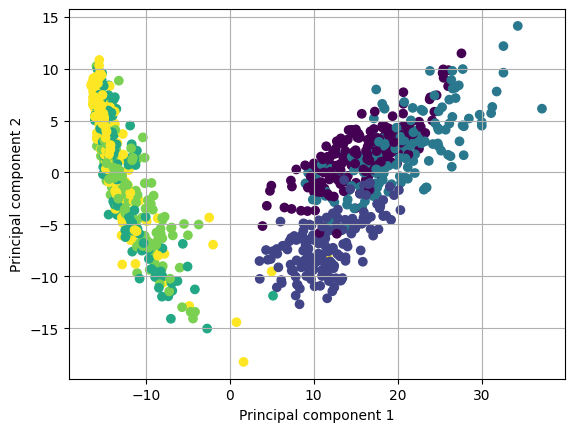

In [20]:
plt.scatter(X_train_pca[:1000, 0], X_train_pca[:1000, 1], c=y_train[:1000])
plt.grid()
plt.xlabel("Principal component 1")
plt.ylabel("Principal component 2")

In [21]:
plt.scatter(X_train_pca[:1000, 3], X_train_pca[:1000, 4], c=y_train[:1000])
plt.grid()
plt.xlabel("Principal component 4")
plt.ylabel("Principal component 5")

Text(0, 0.5, 'Principal component 5')

### Alternative dataset: Wine quality

Please, take this dataset if you are sure you can preprocess it yourself and ready to work with it's features and results, so it is done on your risk.

However you will have interpretable features which can be analysed with shap in last part

In [12]:
!pip install ucimlrepo

In [86]:
import ucimlrepo as uci

In [14]:
dataset = uci.fetch_ucirepo(id=186)

print(dataset.metadata.name, '\n')
print(dataset.metadata.abstract, '\n')
print(dataset.metadata.additional_info.summary, '\n')

Wine Quality 

Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/). 

The two datasets are related to red and white variants of the Portuguese "Vinho Verde" wine. For more details, consult: http://www.vinhoverde.pt/en/ or the reference [Cortez et al., 2009].  Due to privacy and logistic issues, only physicochemical (inputs) and sensory (the output) variables are available (e.g. there is no data about grape types, wine brand, wine selling price, etc.).

These datasets can be viewed as classification or regression tasks.  The classes are ordered and not balanced (e.g. there are many more normal wines than excellent or poor ones). Outlier detection algorithms could be used to detect the few excellent or poor wines. Also, we are not sure if all input variables are relevant. So it could be interesting to t

## Part 1. Fit the model.

Despite optimal parameters (e.g. for xgboost) can be found on the web, we still want you to approximate them by yourself.

In this part just check some (3-5) sets of hyperparameters by hand.

In [16]:
print(y_train.min(), y_train.max())
print(y_test.min(), y_test.max())

1.0 6.0
1.0 6.0


получили, что метки классов идут от 1 до 6, а xgboost хочет чтобы метки начинались с нуля. тогда от всех меток надо будет отнять 1

In [27]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [25]:
y_train_xgb = y_train - 1
y_test_xgb = y_test - 1

In [78]:
params_list = [
    {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 100},
    {'max_depth': 5, 'learning_rate': 0.1, 'n_estimators': 100},
    {'max_depth': 5, 'learning_rate': 0.05, 'n_estimators': 200},
    {'max_depth': 7, 'learning_rate': 0.01, 'n_estimators': 500},
    {'max_depth': 5, 'learning_rate': 0.05, 'n_estimators': 300},
]

In [79]:
for idx, params in enumerate(params_list):
    print(f"Training model with parameters: {params}")
    xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', num_class=6, **params)
    xgb_model.fit(X_train_pca, y_train_xgb)
    y_pred = xgb_model.predict(X_test_pca)
    accuracy = accuracy_score(y_test_xgb, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%\n")

Training model with parameters: {'max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 100}
Accuracy: 89.58%

Training model with parameters: {'max_depth': 5, 'learning_rate': 0.1, 'n_estimators': 100}
Accuracy: 90.36%

Training model with parameters: {'max_depth': 5, 'learning_rate': 0.05, 'n_estimators': 200}
Accuracy: 90.40%

Training model with parameters: {'max_depth': 7, 'learning_rate': 0.01, 'n_estimators': 500}
Accuracy: 88.56%

Training model with parameters: {'max_depth': 5, 'learning_rate': 0.05, 'n_estimators': 300}
Accuracy: 91.04%



In [31]:
xgb.plot_importance(xgb_model, max_num_features=10)
plt.show()

Путём ручного подбора различных наборов гиперпараметров для модели XGBoost мы достигли точности около 90% на тестовых данных. Это позволило нам увидеть, как изменение параметров глубины дерева, скорости обучения и количества деревьев влияет на производительность модели.





## Part 2. Use hyper parameter tuning system

Use [optuna](https://optuna.org/), [hyperopt](http://hyperopt.github.io/hyperopt/) or any other zero order optimizer to find optimal hyper param set.

In [6]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.6 MB/s eta 0:00:00


In [7]:
import optuna
from sklearn.model_selection import cross_val_score, PredefinedSplit
import xgboost as xgb
from sklearn.model_selection import train_test_split

import numpy as np

In [23]:
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_pca, y_train, test_size=0.2, random_state=42)
y_train_split_xgb = y_train_split - 1
y_val_split_xgb = y_val_split - 1

In [71]:
def objective(trial):
    param = {
        'verbosity': 0,
        'objective': 'multi:softmax',
        'num_class': 6,
        'use_label_encoder': False,
        'eval_metric': 'mlogloss',
        'booster': 'gbtree',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
    }

    xgb_model = xgb.XGBClassifier(**param)
    xgb_model.fit(X_train_split, y_train_split_xgb)
    y_pred = xgb_model.predict(X_val_split)
    accuracy = accuracy_score(y_val_split_xgb, y_pred)
    return accuracy

In [73]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-11-17 16:07:10,299] A new study created in memory with name: no-name-13b6a6ef-9a14-4968-8e38-7269c7c9e19f
[I 2024-11-17 16:07:45,543] Trial 0 finished with value: 0.9218218898708361 and parameters: {'max_depth': 10, 'learning_rate': 0.06006123784738559, 'n_estimators': 50}. Best is trial 0 with value: 0.9218218898708361.
[I 2024-11-17 16:09:21,929] Trial 1 finished with value: 0.938137321549966 and parameters: {'max_depth': 9, 'learning_rate': 0.03767018334975855, 'n_estimators': 267}. Best is trial 1 with value: 0.938137321549966.
[I 2024-11-17 16:11:35,422] Trial 2 finished with value: 0.9449354180829368 and parameters: {'max_depth': 7, 'learning_rate': 0.02239739320262231, 'n_estimators': 472}. Best is trial 2 with value: 0.9449354180829368.
[I 2024-11-17 16:12:31,134] Trial 3 finished with value: 0.947654656696125 and parameters: {'max_depth': 7, 'learning_rate': 0.05573617678781262, 'n_estimators': 219}. Best is trial 3 with value: 0.947654656696125.
[I 2024-11-17 16:12:53

In [74]:
print("Best trial:")
trial = study.best_trial

print(f"  Accuracy: {trial.value:.4f}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  Accuracy: 0.9694
  Params:
    max_depth: 4
    learning_rate: 0.17382126297890352
    n_estimators: 441


In [76]:
best_params = trial.params
best_params.update({
    'verbosity': 0,
    'objective': 'multi:softmax',
    'num_class': 6,
    'use_label_encoder': False,
    'eval_metric': 'mlogloss',
})

xgb_best = xgb.XGBClassifier(**best_params)
xgb_best.fit(X_train_pca, y_train_xgb)
y_pred = xgb_best.predict(X_test_pca)
test_accuracy = accuracy_score(y_test_xgb, y_pred)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 92.77%


In [77]:
optuna.visualization.plot_optimization_history(study)
optuna.visualization.plot_param_importances(study)

### Conclusion

Please, write down your thoughts on the experiment results:

Проведя гиперпараметрическую оптимизацию с помощью Optuna, мы повысили точность модели XGBoost на тестовых данных до более чем 90%. Это демонстрирует эффективность автоматизированной настройки параметров для улучшения качества модели. По графику видно, что самый важный гиперпараметр - learning_rate

## Part 3. Interpret the model predictions

Please use [shap](https://github.com/slundberg/shap) to build some plots and try to interpret them.

In [39]:
import shap  # noqa: F401

explainer = shap.KernelExplainer(xgb_best.predict, shap.sample(X_train_pca, 100))
shap_values = explainer(shap.sample(X_train_pca, 100))


  0%|          | 0/100 [00:00<?, ?it/s]

In [28]:
best_params = {
        'verbosity': 0,
        'objective': 'multi:softmax',
        'num_class': 6,
        'use_label_encoder': False,
        'eval_metric': 'mlogloss',
        'booster': 'gbtree',
        'max_depth': 4,
        'learning_rate': 0.17382126297890352,
        'n_estimators': 441,
    }
best_params.update({
    'verbosity': 0,
    'objective': 'multi:softmax',
    'num_class': 6,
    'use_label_encoder': False,
    'eval_metric': 'mlogloss',
})

xgb_best = xgb.XGBClassifier(**best_params)
xgb_best.fit(X_train_pca, y_train_xgb)
y_pred = xgb_best.predict(X_test_pca)
test_accuracy = accuracy_score(y_test_xgb, y_pred)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Test Accuracy: 92.77%


In [46]:
dtest = xgb.DMatrix(X_test)
xgb_best = xgb_best.fit(X_train_pca, y_train_xgb)

In [59]:
X_test_pca = pca.transform(X_test_unique)
y_pred = xgb_best.predict(X_test_pca)

In [29]:
explainer = shap.Explainer(xgb_best)
shap_values = explainer(X_test_pca)

In [33]:
print("SHAP values shape:", shap_values.values.shape)
print("X_test_pca shape:", X_test_pca.shape)

SHAP values shape: (2947, 179, 6)
X_test_pca shape: (2947, 179)


In [30]:
shap.summary_plot(shap_values, X_test_pca)

График показывает важность главных компонент (PCA) в модели XGBoost. Feature 0 и Feature 1 имеют высокое влияние, так как их значения SHAP демонстрируют значительные колебания среди образцов.

In [35]:
shap.initjs()

class_index = 0
shap.force_plot(
    explainer.expected_value[class_index],
    shap_values.values[0, :, class_index],
    X_test_pca[0, :]
)


Этот график визуализирует вклад каждого признака в предсказание модели для первого наблюдения и класса 0

In [51]:
shap_values_test = explainer(X_test_pca[:25])

  0%|          | 0/25 [00:00<?, ?it/s]

In [54]:
shap.initjs()

shap.force_plot(
    explainer.expected_value,
    shap_values_test.values[0],
    X_test_pca[0],
    feature_names=[f"PCA_{i}" for i in range(X_test_pca.shape[1])]
)

График отображает общее влияние признаков на предсказание для первого наблюдения.Исходя из значительного отрицательного вклада PCA_0, модель, вероятно, не относит данное наблюдение к целевому классу (с class_index = 0), а предпочитает другой класс.

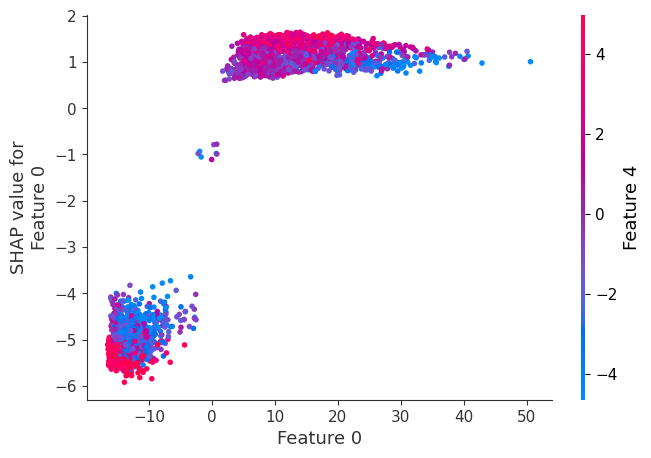

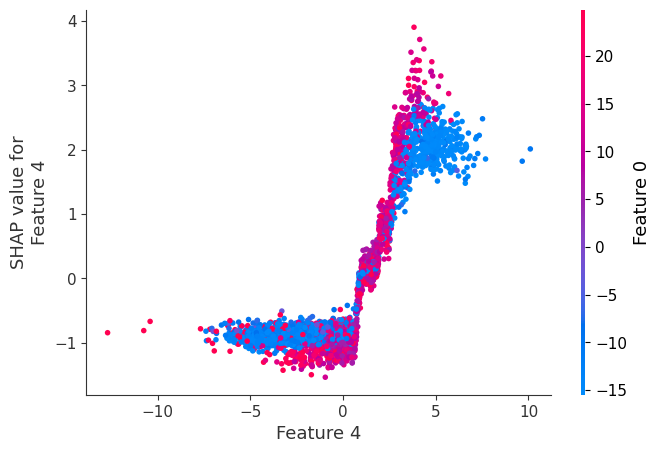

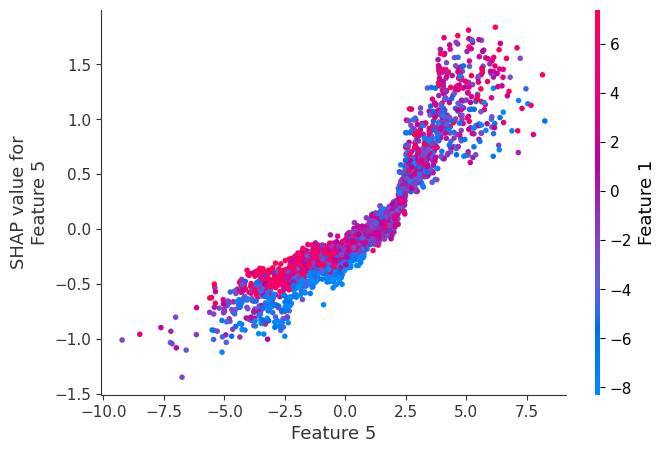

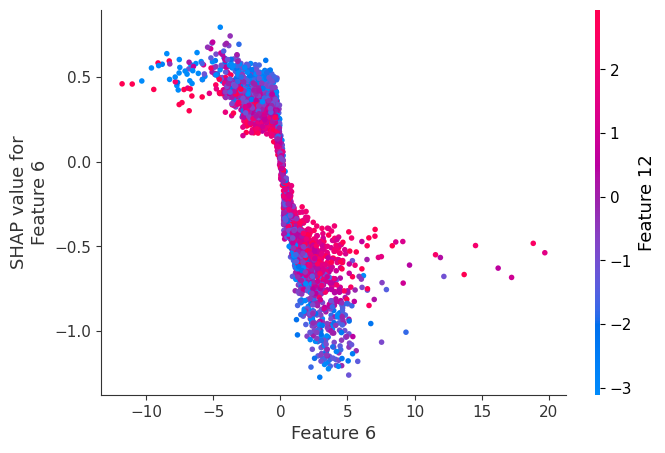

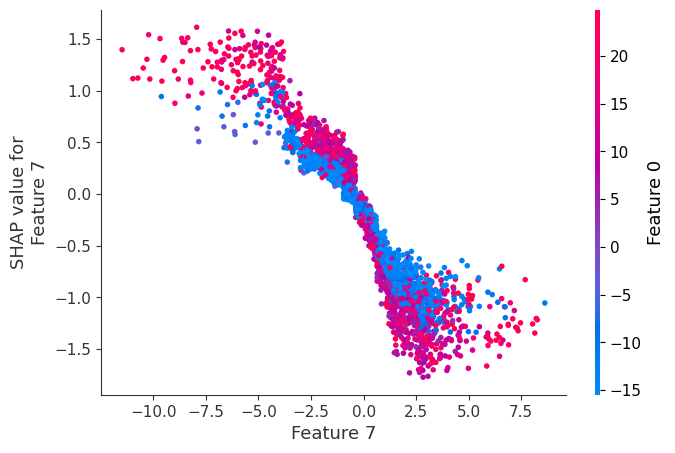

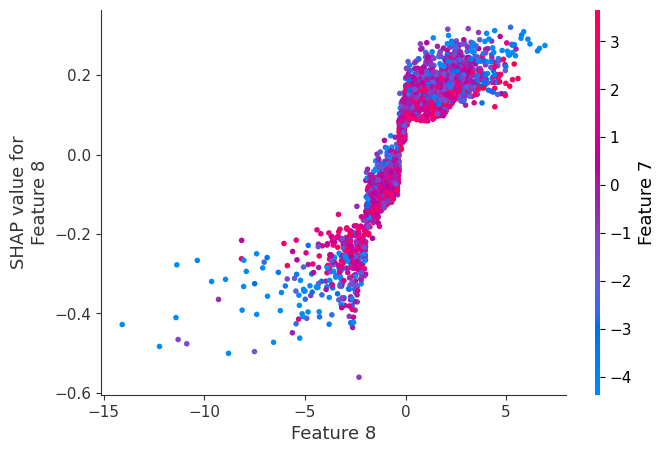

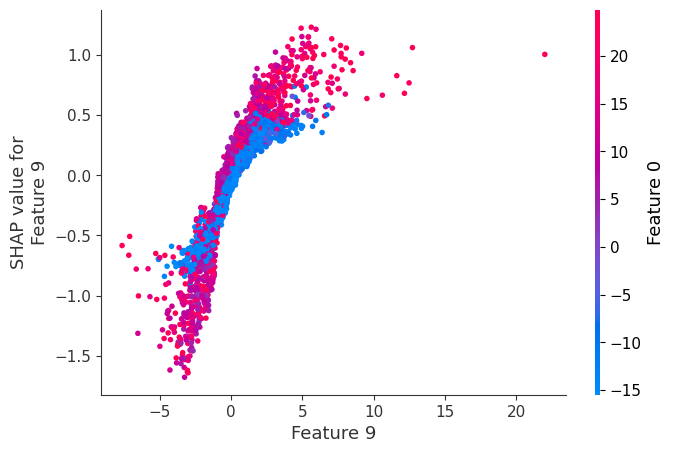

In [37]:
for feature_index in range(10):
    shap.dependence_plot(
        feature_index,
        shap_values.values[..., class_index],
        X_test_pca
    )


Эти графики показывают связь между значением каждого признака и его SHAP-значением. Они выявляют, как изменения в значениях признаков влияют на предсказания модели, позволяя обнаружить паттерны и взаимодействия между признаками. Можно сделать вывод, что нулевая и первая фичи не зависят друг от друга

### Conclusion

Your thoughts about the plots and model behaviour:

Используя SHAP для интерпретации модели XGBoost, мы выявили наиболее влиятельные признаки, влияющие на предсказания. Это признаки 0 и 1 и никак почти между собой не связаны